# Notebook all about Satellite Launches

Satcat dataset: https://celestrak.org/satcat/search.php

```
OBJECT_NAME		Satellite Name(s)

    R/B(1) = Rocket body, first stage
    R/B(2) = Rocket body, second stage
    DEB = Debris
    PLAT = Platform
    Items in parentheses are alternate names
    Items in brackets indicate type of object
    (e.g., BREEZE-M DEB [TANK] = tank)
    An ampersand (&) indicates two or more objects are attached
```

```
OBJECT_ID		International Designator (YYYY-NNNAAA)

    Launch year (4 digits)
    Launch of the year (3 digits)
    Piece of the launch (1-3 alphabetic characters, excluding I and O)
```

```
NORAD_CAT_ID	NORAD Catalog Number
```

```
OBJECT_TYPE		Object type

    PAY = Payload
    R/B = Rocket body
    DEB = Other debris
    UNK = Unknown
```

```
OPS_STATUS_CODE	Operational Status Code
```

```
OWNER			Ownership
```

```
LAUNCH_DATE		Launch Date [year-month-day] (ISO 8601)
```

```
LAUNCH_SITE		Launch Site
```

```
DECAY_DATE		Decay Date, if applicable [year-month-day] (ISO 8601)
```

```
PERIOD			Orbital period [minutes]; null if no data available
```

```
INCLINATION		Inclination [degrees]; null if no data available
```

```
APOGEE			Apogee Altitude [kilometers]; null if no data available
```

```
PERIGEE			Perigee Altitude [kilometers]; null if no data available
```

```
RCS				Radar Cross Section [meters2]; null if no data available
```

```
DATA_STATUS_CODE	Data status code; blank otherwise

    NCE = No Current Elements
    NIE = No Initial Elements
    NEA = No Elements Available
```

```
ORBIT_CENTER	Orbit center

    AS = Asteroid
    CO = Comet
    EA = Earth
    ELx = Earth Lagrange (EL1 = Earth L1, EL2 = Earth L2)
    EM = Earth-Moon Barycenter
    JU = Jupiter
    MA = Mars
    ME = Mercury
    MO = Moon (Earth)
    NE = Neptune
    PL = Pluto
    SA = Saturn
    SS = Solar System Escape
    SU = Sun
    UR = Uranus
    VE = Venus
    NORAD_CAT_ID for docked objects
```

```
ORBIT_TYPE		Orbit type

    ORB = Orbit
    LAN = Landing
    IMP = Impact
    DOC = Docked to another object in the SATCAT
    R/T = Roundtrip
```

In [1]:
# Helper Functions

def classify_orbit(altitude_km):
    """Classifies orbit based on altitude.
    """
    if(altitude_km < 2000):
        return "LEO" # Low Earth Orbit
    elif(altitude_km < 35786):
        return "MEO" # Medium Earth Orbit
    else:
        return "GSO" # Geosynchronous Orbit

# This is a list of sources for specific hard coded satellites
# - https://en.wikipedia.org/wiki/List_of_GPS_satellites
# - https://en.wikipedia.org/wiki/List_of_Galileo_satellites
# - https://en.wikipedia.org/wiki/List_of_GLONASS_satellites
# - https://en.wikipedia.org/wiki/List_of_BeiDou_satellites
def classify_object(object_name):
    # This doesn't work for:
    # - GPS Satellites
    # - Galileo Satellites
    # - GLONASS Satellites (subset of COSMOS satellites)
    # - BeiDou (BeiDou or Compass)
    # - Specification of Dove/RapidEye/SkySat of Flock
    # - Pléiades
    object_class = object_name.split(" ")[0].split("-")[0]
    return object_class

In [2]:
import pandas as pd

limit_norad_id = 25595

# Make sure to execute `download_satcat.sh` first
df = pd.read_csv("satcat.csv")

# Filter to Earth Orbit Center
df = df[df["ORBIT_CENTER"] == "EA"]

# Only consider satellite with payload
df = df[df["OBJECT_TYPE"] == "PAY"]

# Create new column called LAUNCH_YEAR
df["LAUNCH_YEAR"] = df.apply(lambda row: int(row["LAUNCH_DATE"].split("-")[0]), axis=1)

# Convert Dates to a pandas timestamp
df["LAUNCH_DATE"] = pd.to_datetime(df["LAUNCH_DATE"], format='%Y-%m-%d')
df["DECAY_DATE"] = pd.to_datetime(df["DECAY_DATE"], format='%Y-%m-%d')

# Create Orbit Class distrinction
df["ORBIT_CLASS"] = df.apply(lambda row: classify_orbit(row["APOGEE"]), axis=1)

# Create Object Class
# TODO this still uses a heuristic on classifying object classes
df["OBJECT_CLASS"] = df.apply(lambda row: classify_object(row["OBJECT_NAME"]), axis=1)

# Only consider satellite with payload
df = df[df["ORBIT_CLASS"] == "LEO"]

# Hacky way to remove satellites that were launched from the ISS
df = df[(df["LAUNCH_YEAR"] != 1998) | (df["NORAD_CAT_ID"] <= limit_norad_id)]

df

,OBJECT_NAME,OBJECT_ID,NORAD_CAT_ID,OBJECT_TYPE,OPS_STATUS_CODE,OWNER,LAUNCH_DATE,LAUNCH_SITE,DECAY_DATE,PERIOD,INCLINATION,APOGEE,PERIGEE,RCS,DATA_STATUS_CODE,ORBIT_CENTER,ORBIT_TYPE,LAUNCH_YEAR,ORBIT_CLASS,OBJECT_CLASS
1,SPUTNIK 1,1957-001B,2,PAY,D,CIS,1957-10-04,TYMSC,1958-01-03,96.10,65.00,1080.0,64.0,NaN,NaN,EA,IMP,1957,LEO,SPUTNIK
2,SPUTNIK 2,1957-002A,3,PAY,D,CIS,1957-11-03,TYMSC,1958-04-14,103.74,65.33,1659.0,211.0,0.08,NaN,EA,IMP,1957,LEO,SPUTNIK
3,EXPLORER 1,1958-001A,4,PAY,D,US,1958-02-01,AFETR,1970-03-31,88.48,33.15,215.0,183.0,NaN,NaN,EA,IMP,1958,LEO,EXPLORER
5,EXPLORER 3,1958-003A,6,PAY,D,US,1958-03-26,AFETR,1958-06-28,103.60,33.50,1739.0,117.0,NaN,NaN,EA,IMP,1958,LEO,EXPLORER
7,SPUTNIK 3,1958-004B,8,PAY,D,CIS,1958-05-15,TYMSC,1960-04-06,88.43,65.06,255.0,139.0,11.84,NaN,EA,IMP,1958,LEO,SPUTNIK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53985,HJ-2E,2022-132A,54035,PAY,+,PRC,2022-10-12,TAISC,NaT,94.51,97.39,503.0,487.0,NaN,NaN,EA,ORB,2022,LEO,HJ
53992,OBJECT A,2022-133A,54042,PAY,+,PRC,2022-10-14,XICLF,NaT,94.45,35.00,498.0,486.0,NaN,NaN,EA,ORB,2022,LEO,OBJECT
53993,OBJECT B,2022-133B,54043,PAY,+,PRC,2022-10-14,XICLF,NaT,94.44,35.00,498.0,485.0,NaN,NaN,EA,ORB,2022,LEO,OBJECT
53994,OBJECT C,2022-133C,54044,PAY,+,PRC,2022-10-14,XICLF,NaT,94.44,35.00,498.0,485.0,NaN,NaN,EA,ORB,2022,LEO,OBJECT


In [3]:
df.to_csv("satcat_custom.csv")

In [9]:
swarm_df = df[df["OBJECT_CLASS"] == "SPACEBEE"]

# OWNER statistics

also see: https://celestrak.org/satcat/sources.php

In [4]:
def plot_sats(pie_df, title="", cutoff=800):
    df_count = pie_df.groupby(["OWNER"], as_index=False).count().filter(["OWNER", "OBJECT_ID"])
    df_count["OWNER_NEW"] = df_count.apply(lambda row: row["OWNER"] if row["OBJECT_ID"] > cutoff else "OTHER", axis=1)
    df_count.rename(columns = {"OBJECT_ID": "OWNED_SATELLITES"}, inplace=True)
    df_count.groupby(["OWNER_NEW"]).sum().plot(kind="bar", title=title, y="OWNED_SATELLITES")
    

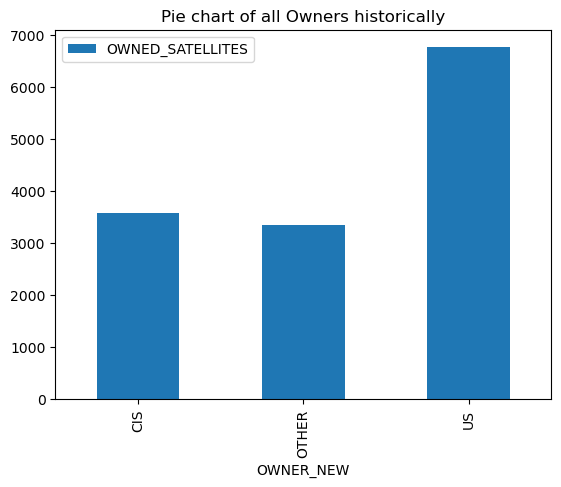

In [5]:
plot_sats(df, title="Pie chart of all Owners historically", cutoff=800)

## Charts of Number of Satellites of the Owners throughout the years

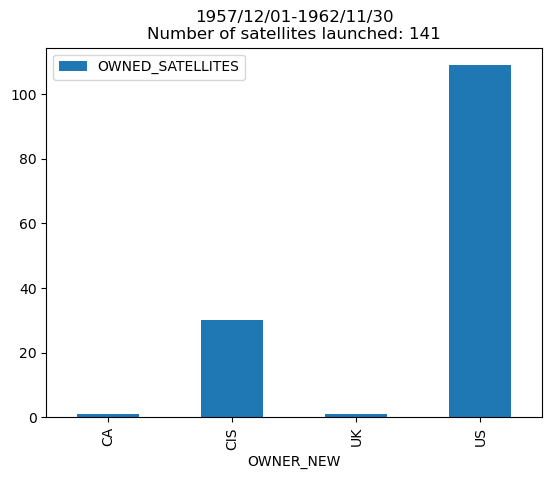

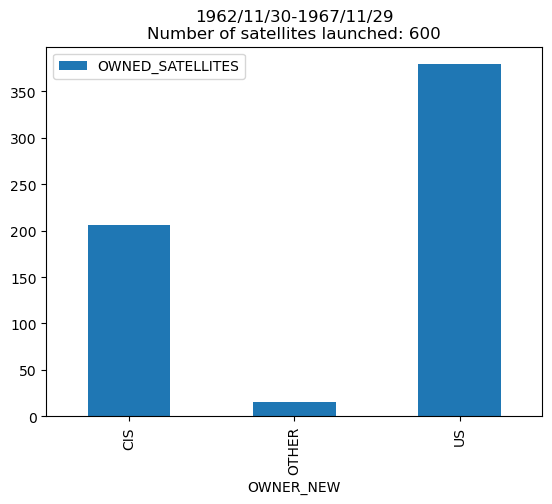

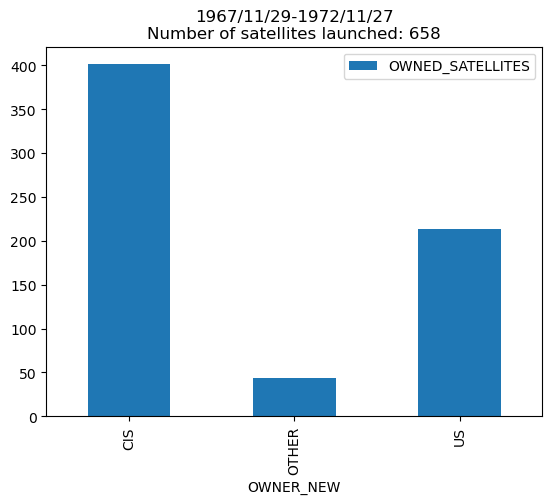

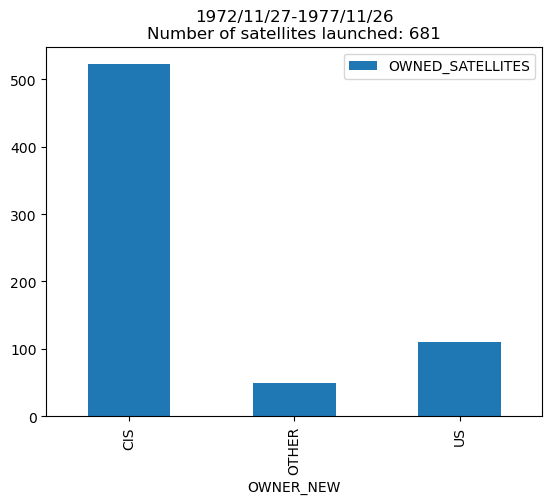

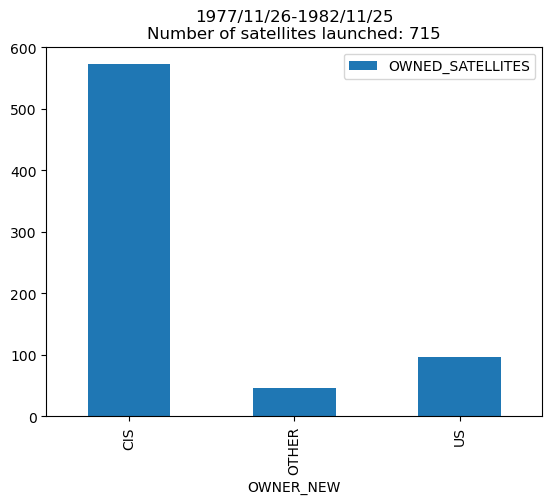

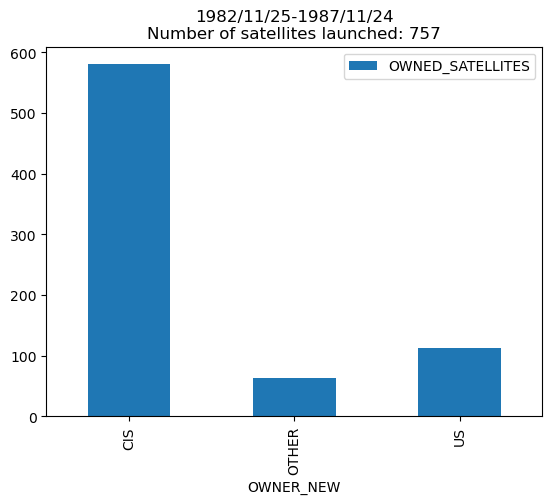

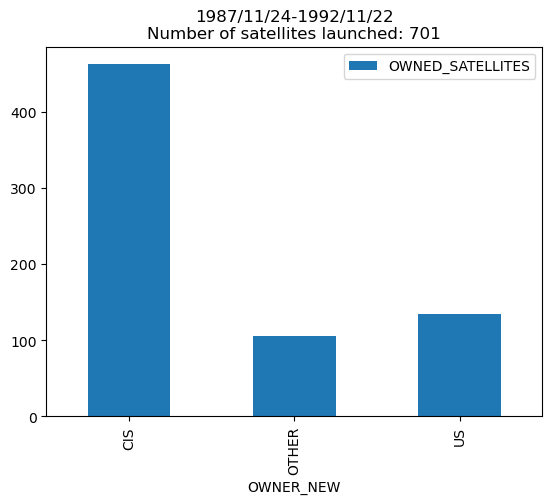

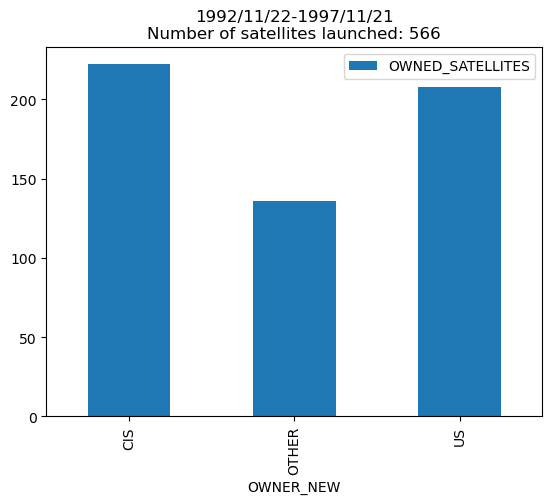

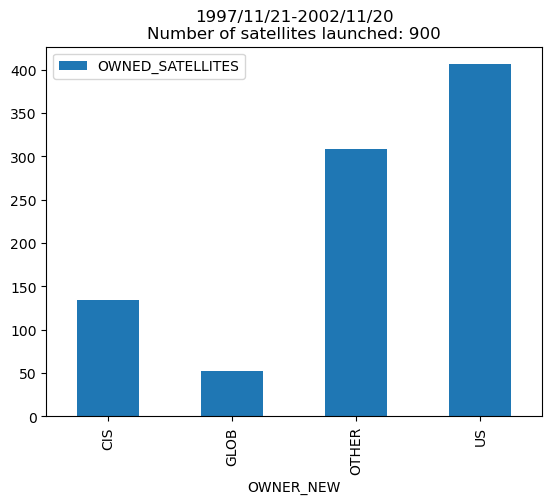

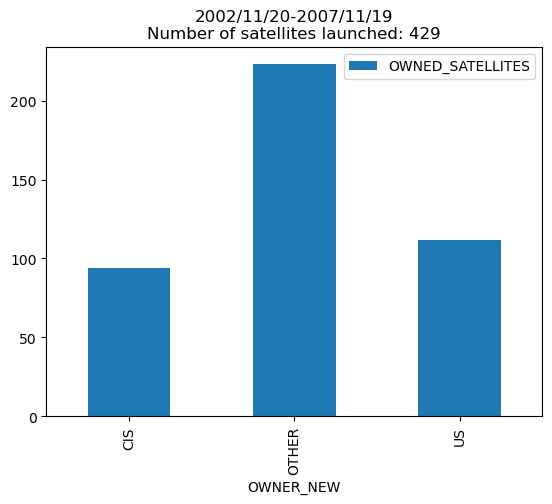

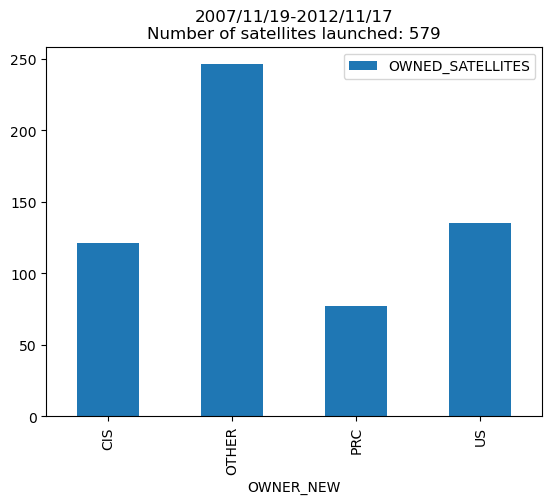

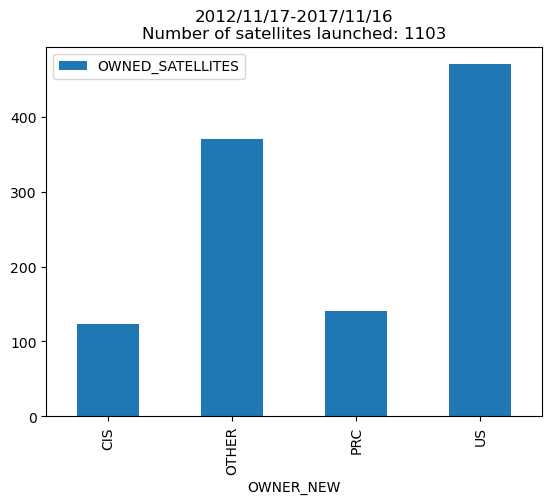

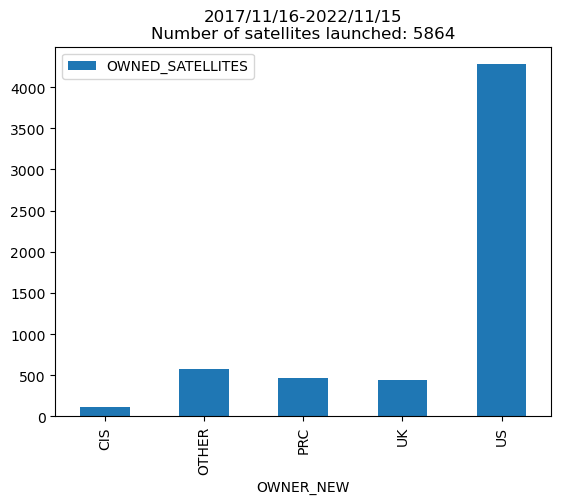

In [24]:
from datetime import timedelta, datetime

dt = timedelta(days=365 * 5)

start_date = datetime.fromisoformat("1957-12-01")
for i in range(13):
    end_date = start_date + dt
    filtered_df = df.loc[(df["LAUNCH_DATE"] >= start_date)
                    &  (df["LAUNCH_DATE"] < end_date)]
    title = start_date.strftime("%Y/%m/%d") + "-" + end_date.strftime("%Y/%m/%d") + "\n" + "Number of satellites launched: " + str(len(filtered_df))
    if i == 0:
        cutoff=0
    else:
        cutoff=50
    plot_sats(filtered_df, title = title, cutoff=cutoff)
    start_date = end_date
    

# Launch over the years statistics

## Large Overview Stuff

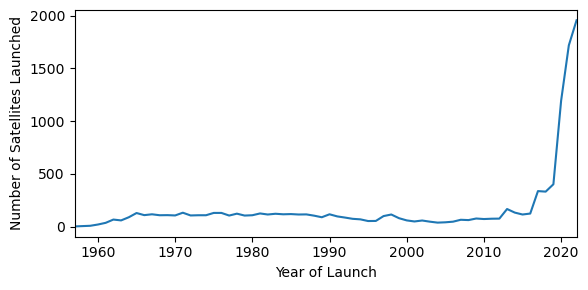

In [78]:
# DataFrame with Orbitclass, Year, and Satellites Launched
orbitclass_df = df.groupby(["LAUNCH_YEAR"], as_index=False).count().filter(["LAUNCH_YEAR", "OBJECT_ID"])
orbitclass_df.rename(columns = {"OBJECT_ID": "SATELLITES_LAUNCHED"}, inplace=True)
orbitclass_df = orbitclass_df.set_index(["LAUNCH_YEAR"])

# Creating synthetic dataset
start_year = 1957
dt_year = 66
years = [y for y in range(start_year, start_year + dt_year)]
synthetic_df = pd.DataFrame(
    {
        "LAUNCH_YEAR": years,
        "SATELLITES_LAUNCHED": [0] * len(years)
    }
)
synthetic_df = synthetic_df.set_index(["LAUNCH_YEAR"])

orbitclass_df = orbitclass_df.join(
                synthetic_df, how="right", rsuffix="SYNTH"
                ).fillna(0).filter(["LAUNCH_YEAR", "SATELLITES_LAUNCHED"]).reset_index()
orbitclass_df = orbitclass_df.rename(columns = {"LAUNCH_YEAR": "Year of Launch"}).set_index("Year of Launch")

#plt.figure(figsize=(2,4))
fig, ax = plt.subplots(figsize=(6, 3))
orbitclass_df.plot(ax=ax)
ax.get_legend().remove()
ax.set_xlim(1957, 2022)
ax.set_ylabel("Number of Satellites Launched")

plt.tight_layout()

plt.savefig("history.pdf")

In [11]:
# LEO, MEO, GEO
# DataFrame with Orbitclass, Year, and Satellites Launched
orbitclass_df = df.groupby(["LAUNCH_YEAR", "ORBIT_CLASS"], as_index=False).count().filter(["LAUNCH_YEAR", "ORBIT_CLASS", "OBJECT_ID"])
orbitclass_df.rename(columns = {"OBJECT_ID": "SATELLITES_LAUNCHED"}, inplace=True)
orbitclass_df = orbitclass_df.set_index(["LAUNCH_YEAR", "ORBIT_CLASS"])

# Creating synthetic dataset
start_year = 1957
dt_year = 66
years = [y for y in range(start_year, start_year + dt_year)]
years = years + years + years
years.sort()
orbit_classes = ["LEO", "MEO", "GSO"] * 66
synthetic_df = pd.DataFrame(
    {
        "LAUNCH_YEAR": years,
        "ORBIT_CLASS": orbit_classes,
        "SATELLITES_LAUNCHED": [0] * len(years)
    }
)
synthetic_df = synthetic_df.set_index(["LAUNCH_YEAR", "ORBIT_CLASS"])

orbitclass_df = orbitclass_df.join(synthetic_df, how="right", rsuffix="SYNTH").fillna(0).filter(["LAUNCH_YEAR", "ORBIT_CLASS", "SATELLITES_LAUNCHED"]).reset_index()


,LAUNCH_YEAR,ORBIT_CLASS,SATELLITES_LAUNCHED
0,1957,LEO,0.0
1,1957,MEO,0.0
2,1957,GSO,0.0
3,1958,LEO,0.0
4,1958,MEO,0.0
...,...,...,...
193,2021,MEO,0.0
194,2021,GSO,0.0
195,2022,LEO,0.0
196,2022,MEO,0.0


In [ ]:
matplitlib.use()

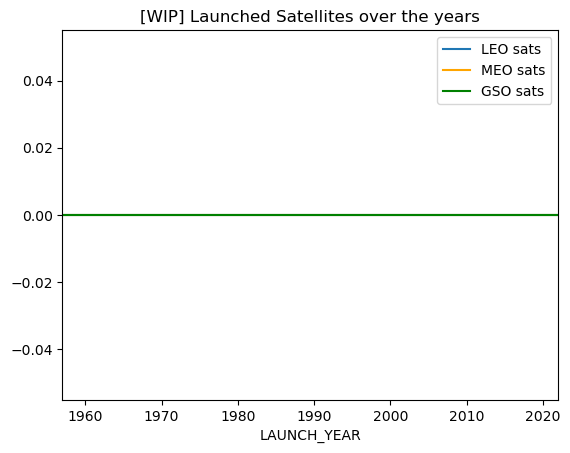

In [7]:
# Plotting
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use("pgf")
#matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
#    'font.family': 'serif',
#    'text.usetex': True,
#    'pgf.rcfonts': False,
#})
ax = orbitclass_df[orbitclass_df["ORBIT_CLASS"] == "LEO"].plot(title="[WIP] Launched Satellites over the years", x="LAUNCH_YEAR", y="SATELLITES_LAUNCHED", label="LEO sats")

orbitclass_df[orbitclass_df["ORBIT_CLASS"] == "MEO"].plot(x="LAUNCH_YEAR", y="SATELLITES_LAUNCHED", color="orange", label="MEO sats", ax=ax)

orbitclass_df[orbitclass_df["ORBIT_CLASS"] == "GSO"].plot(x="LAUNCH_YEAR", y="SATELLITES_LAUNCHED", color="g", label="GSO sats", ax=ax)
ax.set_xlim(1957, 2022)
#plt.savefig('history.pgf')
plt.show()

(1957.0, 2022.0)

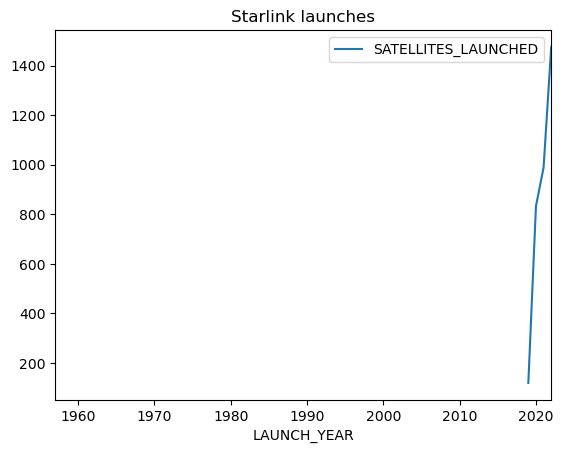

In [32]:
# This plot would give the same information but without the LEO/MEO/GSO distinction
df_count = df[df["OBJECT_CLASS"] == "STARLINK"].groupby(["LAUNCH_YEAR"], as_index=False).count().filter(["LAUNCH_YEAR", "OBJECT_ID"])
df_count.rename(columns = {"OBJECT_ID": "SATELLITES_LAUNCHED"}, inplace=True)
ax = df_count.plot(title="Starlink launches", x="LAUNCH_YEAR", y="SATELLITES_LAUNCHED")
ax.set_xlim(1957, 2022)

(1957.0, 2022.0)

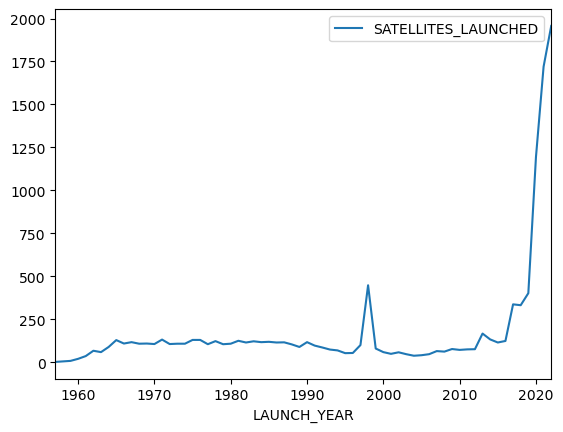

In [33]:
# This plot would give the same information but without the LEO/MEO/GSO distinction
df_count = df.groupby(["LAUNCH_YEAR"], as_index=False).count().filter(["LAUNCH_YEAR", "OBJECT_ID"])
df_count.rename(columns = {"OBJECT_ID": "SATELLITES_LAUNCHED"}, inplace=True)
ax = df_count.plot(x="LAUNCH_YEAR", y="SATELLITES_LAUNCHED")
ax.set_xlim(1957, 2022)

The explosion at the end of the 2010s is to be expected considering the trend of high-density communication satellite constellation. Also see [this](https://www.eso.org/public/announcements/ann19029/)

But what is that peak in the year 1998?

If we take a closer look at the object classes of 1997 until 1999 we see the following:

```
Year 1997
   OBJECT_CLASS  SATELLITES_LAUNCHED
        IRIDIUM                   46
            STS                    8
         COSMOS                    8
        ORBCOMM                    8

Year 1998
    OBJECT_CLASS  SATELLITES_LAUNCHED
           FLOCK                  110
         IRIDIUM                   40
         ORBCOMM                   18
          OBJECT                   13

Year 1999
OBJECT_CLASS  SATELLITES_LAUNCHED
     GLOBALSTAR                   28
        ORBCOMM                    7
            STS                    3
         COSMOS                    3
```

This is interesting. A constellation with the name Flock apparently was launched a bunch in 1998, relatively a lot compared to the previous and next year...

But wait!

The [Flock satellites were actually launched in 2014 from the ISS](https://en.wikipedia.org/wiki/Flock-1). In the satcat database (or more specifically in the international designator), the Flock satellites got the launch date of the ISS instead the year when they were actually launched.

So, if we take out the satellites launched from the ISS, we get the following:

**TODO**

In [34]:
flock_df = df[df["OBJECT_CLASS"] == "FLOCK"]
flock_df1998 = flock_df[flock_df["LAUNCH_YEAR"] == 1998]
flock_df1998

,OBJECT_NAME,OBJECT_ID,NORAD_CAT_ID,OBJECT_TYPE,OPS_STATUS_CODE,OWNER,LAUNCH_DATE,LAUNCH_SITE,DECAY_DATE,PERIOD,INCLINATION,APOGEE,PERIGEE,RCS,DATA_STATUS_CODE,ORBIT_CENTER,ORBIT_TYPE,LAUNCH_YEAR,ORBIT_CLASS,OBJECT_CLASS
39511,FLOCK 1-3,1998-067DG,39512,PAY,D,US,1998-11-20,TYMSC,2014-05-15,88.26,51.62,195.0,181.0,0.1068,NaN,EA,IMP,1998,LEO,FLOCK
39512,FLOCK 1-1,1998-067DH,39513,PAY,D,US,1998-11-20,TYMSC,2014-06-09,87.65,51.60,162.0,155.0,0.0797,NaN,EA,IMP,1998,LEO,FLOCK
39513,FLOCK 1-2,1998-067DJ,39514,PAY,D,US,1998-11-20,TYMSC,2014-05-25,87.81,51.63,170.0,162.0,0.0784,NaN,EA,IMP,1998,LEO,FLOCK
39514,FLOCK 1-4,1998-067DK,39515,PAY,D,US,1998-11-20,TYMSC,2014-06-18,88.03,51.62,185.0,169.0,0.0770,NaN,EA,IMP,1998,LEO,FLOCK
39517,FLOCK 1-5,1998-067DL,39518,PAY,D,US,1998-11-20,TYMSC,2014-06-02,87.51,51.61,154.0,148.0,0.0943,NaN,EA,IMP,1998,LEO,FLOCK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41763,FLOCK 2E'-15,1998-067KL,41764,PAY,D,US,1998-11-20,TYMSC,2018-11-10,90.07,51.63,284.0,271.0,0.0964,NaN,EA,IMP,1998,LEO,FLOCK
41768,FLOCK 2E'-18,1998-067KM,41769,PAY,D,US,1998-11-20,TYMSC,2018-11-07,90.04,51.62,284.0,269.0,0.1039,NaN,EA,IMP,1998,LEO,FLOCK
41775,FLOCK 2E'-17,1998-067KN,41776,PAY,D,US,1998-11-20,TYMSC,2018-06-26,87.80,51.61,170.0,160.0,0.1024,NaN,EA,IMP,1998,LEO,FLOCK
41776,FLOCK 2E'-19,1998-067KP,41777,PAY,D,US,1998-11-20,TYMSC,2018-05-12,87.64,51.61,159.0,156.0,0.0593,NaN,EA,IMP,1998,LEO,FLOCK


In [9]:
flock_df2014 = flock_df[flock_df["LAUNCH_YEAR"] == 2014]
flock_df2014

,OBJECT_NAME,OBJECT_ID,NORAD_CAT_ID,OBJECT_TYPE,OPS_STATUS_CODE,OWNER,LAUNCH_DATE,LAUNCH_SITE,DECAY_DATE,PERIOD,INCLINATION,APOGEE,PERIGEE,RCS,DATA_STATUS_CODE,ORBIT_CENTER,ORBIT_TYPE,LAUNCH_YEAR,ORBIT_CLASS,OBJECT_CLASS


In [54]:


df1998 = df[(df["LAUNCH_YEAR"] == 1998) & (df["NORAD_CAT_ID"] > limit_norad_id)]
#df1998 = df1998[df1998["NORAD_CAT_ID"] > limit_norad_id]
df1998.to_csv("launched_iss.csv")

## Object Class Shenanigans

In [4]:
import numpy as np
def aggregate_class(class_df):
    count_df = class_df.groupby(["OBJECT_CLASS"], as_index=False).count().filter(["OBJECT_CLASS", "OBJECT_ID"])
    count_df.rename(columns = {"OBJECT_ID": "SATELLITES_LAUNCHED"}, inplace=True)
    count_df.set_index("OBJECT_CLASS", inplace=True)
    
    temp_df = class_df.dropna(subset=["DECAY_DATE"])
    count2_df = class_df.drop(temp_df.index).filter(["OBJECT_CLASS", "OBJECT_ID"]).groupby(["OBJECT_CLASS"], as_index=False).count()
    count2_df.rename(columns = {"OBJECT_ID": "ACTIVE_SATELLITES"}, inplace=True)
    count2_df.set_index("OBJECT_CLASS", inplace=True)
    
    result_df = count_df.join(count2_df)
    result_df["ACTIVE_SATELLITES"] = result_df["ACTIVE_SATELLITES"].fillna(0).astype(int)
    result_df["INACTIVE_SATELLITES"] = result_df.apply(lambda row: row["SATELLITES_LAUNCHED"] - row["ACTIVE_SATELLITES"], axis=1)
    return result_df

def print_topN_classes(entire_df, year, N=5):
    filtered_df = entire_df[entire_df["LAUNCH_YEAR"] == year]

    count_df = aggregate_class(filtered_df)
    count_df = count_df.sort_values(["SATELLITES_LAUNCHED"], ascending=False)[:N]
    
    print(count_df)

start_year = 1957
end_year = 2023
#for year in range(start_year, end_year):
#    print("Year", year)
#    print_topN_classes(df[df["ORBIT_CLASS"] == "LEO"], year, N=5)

agg_df = aggregate_class(df)
agg_df.sort_values(["SATELLITES_LAUNCHED"], ascending=False)[:20]

,SATELLITES_LAUNCHED,ACTIVE_SATELLITES,INACTIVE_SATELLITES
OBJECT_CLASS,,,
STARLINK,3417,3176,241
COSMOS,2558,1149,1409
FLOCK,466,309,157
ONEWEB,428,426,2
OPS,412,169,243
USA,199,192,7
OBJECT,195,184,11
IRIDIUM,170,104,66
PROGRESS,167,0,167


In [12]:
start_year  = 1997
end_year    = 2000
for year in range(start_year, end_year):
    print("Year", year)
    print_topN_classes(df[df["ORBIT_CLASS"] == "LEO"], year, N=10)

Year 1997
              SATELLITES_LAUNCHED  ACTIVE_SATELLITES  INACTIVE_SATELLITES
OBJECT_CLASS                                                             
IRIDIUM                        46                 21                   25
STS                             8                  0                    8
COSMOS                          8                  5                    3
ORBCOMM                         8                  8                    0
PROGRESS                        4                  0                    4
GONETS                          3                  3                    0
DUMMY                           2                  2                    0
SOYUZ                           2                  0                    2
CELESTIS                        1                  0                    1
ORBVIEW                         1                  1                    0
Year 1998
              SATELLITES_LAUNCHED  ACTIVE_SATELLITES  INACTIVE_SATELLITES
OBJECT_CLASS      

In [18]:
flock_df = df[df["OBJECT_CLASS"]=="FLOCK"]
flock_df = flock_df[flock_df["LAUNCH_YEAR"]==1998]
flock_df

,OBJECT_NAME,OBJECT_ID,NORAD_CAT_ID,OBJECT_TYPE,OPS_STATUS_CODE,OWNER,LAUNCH_DATE,LAUNCH_SITE,DECAY_DATE,PERIOD,INCLINATION,APOGEE,PERIGEE,RCS,DATA_STATUS_CODE,ORBIT_CENTER,ORBIT_TYPE,LAUNCH_YEAR,ORBIT_CLASS,OBJECT_CLASS
39511,FLOCK 1-3,1998-067DG,39512,PAY,D,US,1998-11-20,TYMSC,2014-05-15,88.26,51.62,195.0,181.0,0.1068,NaN,EA,IMP,1998,LEO,FLOCK
39512,FLOCK 1-1,1998-067DH,39513,PAY,D,US,1998-11-20,TYMSC,2014-06-09,87.65,51.60,162.0,155.0,0.0797,NaN,EA,IMP,1998,LEO,FLOCK
39513,FLOCK 1-2,1998-067DJ,39514,PAY,D,US,1998-11-20,TYMSC,2014-05-25,87.81,51.63,170.0,162.0,0.0784,NaN,EA,IMP,1998,LEO,FLOCK
39514,FLOCK 1-4,1998-067DK,39515,PAY,D,US,1998-11-20,TYMSC,2014-06-18,88.03,51.62,185.0,169.0,0.0770,NaN,EA,IMP,1998,LEO,FLOCK
39517,FLOCK 1-5,1998-067DL,39518,PAY,D,US,1998-11-20,TYMSC,2014-06-02,87.51,51.61,154.0,148.0,0.0943,NaN,EA,IMP,1998,LEO,FLOCK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41763,FLOCK 2E'-15,1998-067KL,41764,PAY,D,US,1998-11-20,TYMSC,2018-11-10,90.07,51.63,284.0,271.0,0.0964,NaN,EA,IMP,1998,LEO,FLOCK
41768,FLOCK 2E'-18,1998-067KM,41769,PAY,D,US,1998-11-20,TYMSC,2018-11-07,90.04,51.62,284.0,269.0,0.1039,NaN,EA,IMP,1998,LEO,FLOCK
41775,FLOCK 2E'-17,1998-067KN,41776,PAY,D,US,1998-11-20,TYMSC,2018-06-26,87.80,51.61,170.0,160.0,0.1024,NaN,EA,IMP,1998,LEO,FLOCK
41776,FLOCK 2E'-19,1998-067KP,41777,PAY,D,US,1998-11-20,TYMSC,2018-05-12,87.64,51.61,159.0,156.0,0.0593,NaN,EA,IMP,1998,LEO,FLOCK


## Lifetime of Object Classes

In [13]:
decayed_df = df.dropna(subset=["DECAY_DATE"])
decayed_df["LIFETIME"] = decayed_df.apply(lambda row: row["DECAY_DATE"] - row["LAUNCH_DATE"], axis=1)

/tmp/ipykernel_1490431/810433723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decayed_df["LIFETIME"] = decayed_df.apply(lambda row: row["DECAY_DATE"] - row["LAUNCH_DATE"], axis=1)


In [14]:
mean_df = decayed_df.filter(["OBJECT_CLASS", "LIFETIME"]).groupby(["OBJECT_CLASS"], as_index=False).mean()
mean_df.set_index("OBJECT_CLASS", inplace=True)
count_df = decayed_df.filter(["OBJECT_CLASS", "OBJECT_ID"]).groupby(["OBJECT_CLASS"], as_index=False).count()
count_df.rename(columns = {"OBJECT_ID": "NUMBER"}, inplace=True)
#mean_df = mean_df.sort_values(["LIFETIME"], ascending=False)
count_df.set_index("OBJECT_CLASS", inplace=True)

decayed_classes_df = count_df.join(mean_df)
decayed_classes_df.sort_values("NUMBER", ascending=False)[:20]

,NUMBER,LIFETIME
OBJECT_CLASS,,
COSMOS,1409,757 days 13:29:25.507452096
OPS,243,712 days 07:12:35.555555552
STARLINK,241,420 days 18:43:19.170124480
PROGRESS,167,95 days 08:54:36.646706587
SOYUZ,164,139 days 15:39:30.731707318
FLOCK,157,4980 days 22:28:16.815286656
STS,135,13 days 06:02:40
MOLNIYA,128,4618 days 17:26:15
IRIDIUM,66,6880 days 07:16:21.818181760


In [22]:
df[df["OBJECT_CLASS"] == "ISS"]

,OBJECT_NAME,OBJECT_ID,NORAD_CAT_ID,OBJECT_TYPE,OPS_STATUS_CODE,OWNER,LAUNCH_DATE,LAUNCH_SITE,DECAY_DATE,PERIOD,INCLINATION,APOGEE,PERIGEE,RCS,DATA_STATUS_CODE,ORBIT_CENTER,ORBIT_TYPE,LAUNCH_YEAR,ORBIT_CLASS,OBJECT_CLASS
25543,ISS (ZARYA),1998-067A,25544,PAY,+,ISS,1998-11-20,TYMSC,NaT,92.9,51.64,419.0,414.0,399.0524,NaN,EA,ORB,1998,LEO,ISS


# By Service Type

We try to hardcode a `OBJECT_CLASS` to `SERVICE_TYPE` map based on information on [wikipedia](https://en.wikipedia.org/wiki/Satellite_constellation) and other information like:

- Whether or not the satellite is commercial...

In [33]:
df[df["OBJECT_CLASS"] == "RADARSAT"]

,OBJECT_NAME,OBJECT_ID,NORAD_CAT_ID,OBJECT_TYPE,OPS_STATUS_CODE,OWNER,LAUNCH_DATE,LAUNCH_SITE,DECAY_DATE,PERIOD,INCLINATION,APOGEE,PERIGEE,RCS,DATA_STATUS_CODE,ORBIT_CENTER,ORBIT_TYPE,LAUNCH_YEAR,ORBIT_CLASS,OBJECT_CLASS
23709,RADARSAT-1,1995-059A,23710,PAY,-,CA,1995-11-04,AFWTR,NaT,100.63,98.56,789.0,788.0,5.9319,NaN,EA,ORB,1995,LEO,RADARSAT
32381,RADARSAT-2,2007-061A,32382,PAY,+,CA,2007-12-14,TYMSC,NaT,100.70,98.58,793.0,791.0,8.3810,NaN,EA,ORB,2007,LEO,RADARSAT


In [ ]:
# Notes on this obj_to_service mapping:
# - I consider weather satellites as observation satellites
obj_to_service = {
    "COMMUNICATION": [
        "STARLINK",
        "IRIDIUM",
        "GLOBALSTAR",
        "ORBCOMM"
        
    ],
    "NAVIGATION": [
        "GPS",
        "GALILEO",
        "GLONASS",
        "BEIDOU"
    ],
    "OBSERVATION": [
        "SPIRE",
        "FLOCK"   
    ]
}

# Groundstation Service Provider

- KSAT
- "ITU" Filings, ask Martin Luelf?
- https://www.itu.int/ITU-R/go/space/snl/en

# Using ELSAT OMM XML

directly downloaded from https://www.space-track.org/#recent

In [40]:
import pandas as pd

df = pd.read_xml("./elsat_omm.xml")

In [41]:
df

,id,version,header,body
0,CCSDS_OMM_VERS,2.0,NaN,NaN
1,CCSDS_OMM_VERS,2.0,NaN,NaN
2,CCSDS_OMM_VERS,2.0,NaN,NaN
3,CCSDS_OMM_VERS,2.0,NaN,NaN
4,CCSDS_OMM_VERS,2.0,NaN,NaN
...,...,...,...,...
7753,CCSDS_OMM_VERS,2.0,NaN,NaN
7754,CCSDS_OMM_VERS,2.0,NaN,NaN
7755,CCSDS_OMM_VERS,2.0,NaN,NaN
7756,CCSDS_OMM_VERS,2.0,NaN,NaN


In [44]:
import bs4

In [45]:
asa = bs4.BeautifulSoup()

In [46]:
asa.